# Global constants

In [14]:
# GRAIN_TYPE = 'Wheat'
# GRAIN_TYPE = 'Oats'
# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_1/model_bulk_density/' + GRAIN_TYPE + '_t1_dnn_bd.h5'

In [15]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt

#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold

print(tf.__version__)

2.4.1


In [16]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Helper functions

In [17]:
def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(predictions, trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

# 1. Load the Dataset
We are going to use one dataset from UCI Machine Learning Repository. You can download the Energy Efficient Dataset using the following link. You can use pandas to download and open the data set which is in excel format or load from your local machine.

In [18]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)

print("From USDA: ", URL)

df.head()

From USDA:  ../Datasets/processed/Corn.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
0,0,HI BRED 31D58,6.0,3.3,26.23,0.5602,9.2688,142.982,-217.018,3.595,0.984
1,1,HI BRED 31D58,7.0,3.3,26.23,0.5602,11.9033,114.498,-245.502,3.476,1.067
2,2,HI BRED 31D58,8.0,3.3,26.23,0.5602,14.9916,85.785,-274.215,3.383,1.163
3,3,HI BRED 31D58,9.0,3.3,26.23,0.5602,17.7882,63.083,-296.917,3.252,1.205
4,4,HI BRED 31D58,10.0,3.3,26.23,0.5602,20.2646,38.844,-321.156,3.165,1.224


# 2. Overview of data


In [19]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary
count,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000
mean,667.980377,9.616604,5.283170,19.173464,0.732730,18.574415,7.843992,-462.193766,3.241382,0.900775
std,388.591085,3.036191,2.049772,7.206516,0.101502,6.337757,89.287814,190.960971,0.603906,0.508211
min,0.000000,5.000000,2.000000,8.060000,0.448800,8.002300,-179.974000,-1115.206000,2.405000,0.242000
25%,331.000000,7.000000,3.300000,13.910000,0.663100,13.112200,-54.978000,-573.131000,2.780000,0.477000
50%,662.000000,9.000000,4.400000,18.580000,0.748300,18.344300,11.128000,-402.701000,3.094000,0.821000
75%,1007.000000,12.000000,7.700000,25.430000,0.816100,24.152200,77.870000,-323.806000,3.526000,1.213000
max,1338.000000,18.000000,8.500000,34.400000,0.901700,29.897000,179.949000,-150.217000,5.979000,3.294000


In [20]:
# Dimension of the dataset
df.shape

(1325, 11)

In [21]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
dtype: int64

## Violin plot for visualizing bulk density

In [22]:
# import seaborn

# # Violin plot

# # use to set style of background of plot
# # seaborn.set(style = 'whitegrid')

# # loading data-set
# tip = seaborn.load_dataset('tips')
# plt.figure(figsize=(4,7))

# seaborn.violinplot(y ='Density',
# 				data = df,
# 				inner="points")


# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [23]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary'
                    # 'Density'         
            ]]

df_targets = df[['Density']]
# df_targets = df[['M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [24]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.20
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [25]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler(feature_range=(0,1))

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)
# y_train_norm = y_train

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
# y_val_norm = scaler_output.fit_transform(y_val)
y_val_norm = y_val

In [26]:
# # loading data-set
# tip = seaborn.load_dataset('tips')
# plt.figure(figsize=(4,6))

# seaborn.violinplot(y =y_train,
# 				inner="points")

# seaborn.violinplot(y =y_train_norm,
# 				inner="points")

In [27]:
min(y_train_norm)

array([0.])

# K-cross Validation
* Input features: 7
* Output targets: *** 1 ***


## Defining the model

In [28]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  
  my_model = Sequential([   
    layers.Dense(64, input_shape=(7,), activation='relu', 
                #  kernel_regularizer=regularizers.l2(0.01)
                 ),
      # layers.BatchNormalization(),  # Batch normalization layer
      # layers.Dropout(0.1),

      layers.Dense(64, activation='relu', 
                  #  kernel_regularizer=regularizers.l2(0.01)
                   ),

      # layers.Dense(16, activation='relu', 
      # #             #  kernel_regularizer=regularizers.l2(0.01)
      #              ),
      # layers.BatchNormalization(),  # Batch normalization layer
      # layers.Dropout(0.1),

      layers.Dense(1, activation='sigmoid')  # Output layer with ONE neuron
      # layers.Dense(1, activation='linear')  # Output layer with ONE neuron
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

2023-08-15 15:43:45.810057: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 15:43:45.811417: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-08-15 15:43:45.811648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-15 15:43:45.811760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 4090 computeCapability: 8.9
coreClock: 2.52GHz coreCount: 128 deviceMemorySize: 23.64GiB deviceMemoryBandwidth

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                512       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


## Running Model with KCV

In [29]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler

NUM_EPOCHS = 200
BATCH_SIZE = 10
K_FOLD_SPLITS = 2


# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y = y_train_norm[:,0]

X = X_train_norm

i = 0
arr_loss = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None

# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, testX = np.array(X[train_indices]), np.array(X[test_indices])
  trainY = (Y[train_indices])
  testY = (Y[test_indices])

  model = my_model()
  # Define the learning rate scheduler callback
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (testX, testY)
  )


  #testing on validation set process
  loss, rmse = model.evaluate(x = testX, y = testY, verbose=1)
  print(f"Loss = {loss}, rmse = {rmse}" )

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)

####################### Iteration   0  #######################
Epoch 1/200


2023-08-15 15:43:46.705087: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-08-15 15:43:46.705322: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 4491685000 Hz
2023-08-15 15:43:46.809444: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


45/45 [==============================] - 0s 4ms/step - loss: 0.0679 - accuracy: 0.0000e+00 - val_loss: 0.0606 - val_accuracy: 0.0089
Epoch 2/200
45/45 [==============================] - 0s 1ms/step - loss: 0.0603 - accuracy: 0.0060 - val_loss: 0.0546 - val_accuracy: 0.0089
Epoch 3/200
45/45 [==============================] - 0s 1ms/step - loss: 0.0590 - accuracy: 0.0138 - val_loss: 0.0495 - val_accuracy: 0.0089
Epoch 4/200
45/45 [==============================] - 0s 1ms/step - loss: 0.0532 - accuracy: 0.0167 - val_loss: 0.0453 - val_accuracy: 0.0089
Epoch 5/200
45/45 [==============================] - 0s 1ms/step - loss: 0.0503 - accuracy: 0.0052 - val_loss: 0.0419 - val_accuracy: 0.0089
Epoch 6/200
45/45 [==============================] - 0s 1ms/step - loss: 0.0435 - accuracy: 0.0073 - val_loss: 0.0386 - val_accuracy: 0.0089
Epoch 7/200
45/45 [==============================] - 0s 993us/step - loss: 0.0426 - accuracy: 0.0058 - val_loss: 0.0358 - val_accuracy: 0.0089
Epoch 8/200
45/45 [

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No handles with labels found to put in legend.


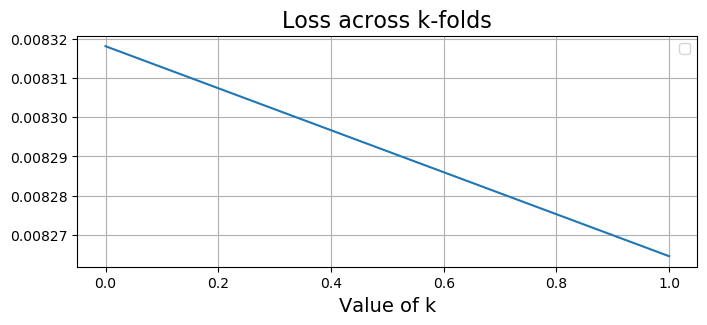

In [30]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

## Loss curves

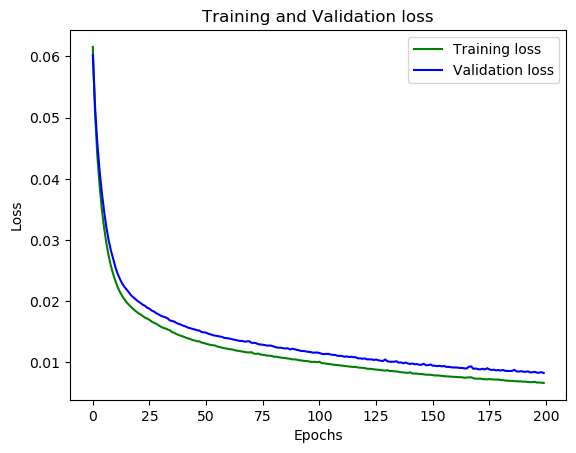

In [31]:

# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

## Prediction on Test Dataset

In [32]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)
# y_test_norm = y_test

In [33]:
import time

start_time = time.time()
pred_bd = best_model.predict(X_test_norm)
end_time = time.time()

# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")

Y_pred = scaler_output.inverse_transform(pred_bd)
# Y_pred = pred_bd

Y_actual = np.array(y_test)

Elapsed time: 0.033 seconds


## Plotting Real vs Predicted values

Maxval here is:  0.8963


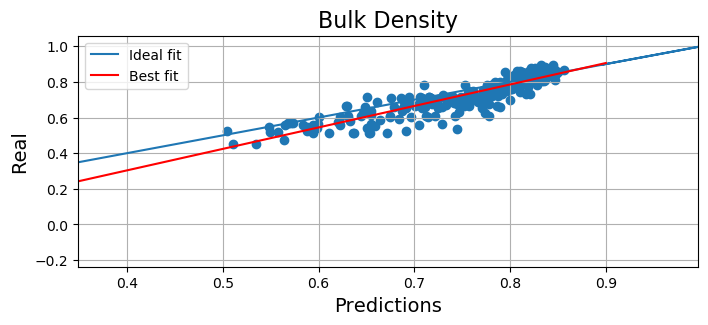

In [38]:
# BULK DENSITY
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Bulk Density")
plt.xlim([min(min(Y_pred[:,0]), min(Y_actual[:,0]))-0.1, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+0.1])

a, b = np.polyfit(x = Y_pred[:, 0], y = Y_actual[:, 0], deg=1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()

plt.savefig('../Poster contents/Results/obj_1_BD.svg', dpi=300, transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [35]:
from sklearn.metrics import r2_score

# BULK DENSITY
#   - R-squared
# mc_r2_score = r2_score(y_pred=Y_pred[:, 0], y_true=Y_actual[:, 0])
# print(mc_r2_score)

# Trying smtg new
r_sq = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print('BD r_sq: ', r_sq)

BD r_sq:  0.8063394721858893


### RMSE for test dataset

In [36]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE: ', rmse)

RMSE:  0.05504633926052148
